In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration
from util import *

In [2]:
# on the cblgpu01 or 06 computer
checkpoints_methods = [
    #('run-20210520_201621-1tac73ie', 'Ens 3'), ('run-20210520_232903-3edza10c', 'MCDrop 3, rate 0.1'), 
    #('run-20210520_215226-2829ms12', 'NCEns 3 anneal'), ('run-20210520_183333-q4byxnks', 'NCEns 3 w2'), 
    ('run-20210521_002758-6tow019f', 'Single'), 
    ('run-20210521_133234-2zgcfz21', 'Ens 5'),
    #('run-20210521_135148-2174fa8f', 'NCEns 5 anneal'), 
    # ('run-20210521_135356-1z9btw0n', 'NCEns 5 w2'),
    # ('run-20210521_135447-18fwsxyd', 'MCDrop 5, rate 0.1')
    ('run-20210606_220130-3k51e8yb', 'CEEns 5 w0.8'),
    # ('run-20210607_053840-2ix1adts', 'CEEns 5 w0.9')
    ]

checkpoints_annealing = [
    #('run-20210523_202732-2o5htajn', 'NCEns-5 w10 decay0.985'),
    #('run-20210524_054053-k9s2cx2i', 'NCEns-5 w5'),
    # ('run-20210523_224635-2m4ul8lw', 'NCEns-5 w10 decay0.98'),
    ('run-20210524_010345-9gt6gv8b', 'NCEns-5 w100 decay0.93'),
    #('run-20210524_032114-b14iu9ek', 'NCEns-5 w100 decay0.9')
]

In [3]:
checkpoints = checkpoints_methods + checkpoints_annealing

In [4]:
device='cuda'
checkpoint_epoch = 180


In [5]:
# for CIFAR, shifted ID data
corruption_intensity = 4
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, 
                                            corruptions=constants.CORRUPTIONS, intensities=[corruption_intensity], 
                                            is_cifar10=model_args.dataset_type=='cifar10')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, _, _ = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [00:14<00:00, 99.53batch/s]
Results: 
Accuracy: 0.6187684210526316
NLL: 2.391129793448197
ECE: 0.28229436558586984
Brier: 0.6290117104680915
Initialising an ensemble of 5 networks
SGD optimizer
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
  0%|          | 5/1485 [00:00<01:19, 18.56batch/s]/homes/gp491/deepens/metrics.py:230: UserWa

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Count vs Confidence. Corrupted, intensity 4')

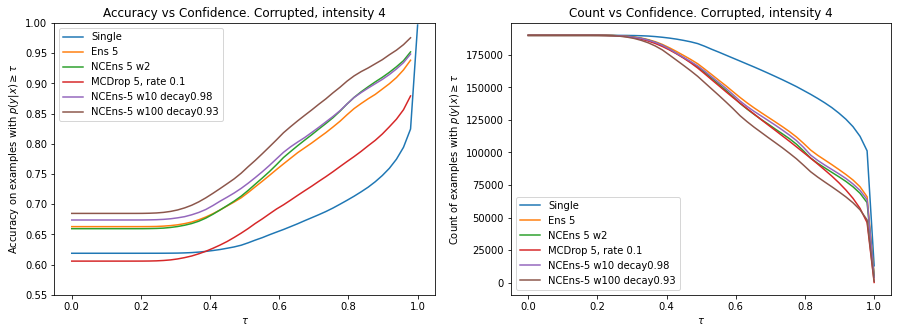

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
# plt.plot(thresholds, thresholds, '--')
plt.ylim(0.55, 1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Corrupted, intensity {corruption_intensity}')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Corrupted, intensity {corruption_intensity}')

Single
78220.0
Ens 5
50334.0
NCEns 5 w2
47008.0
MCDrop 5, rate 0.1
25881.0
NCEns-5 w10 decay0.98
49137.0
NCEns-5 w100 decay0.93
32844.0


Text(0.5, 1.0, 'Count vs Entropy. Corrupted, intensity 4')

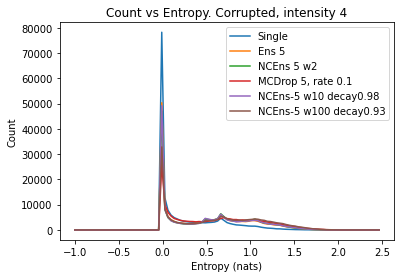

In [8]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Corrupted, intensity {corruption_intensity}')

## OOD Data

In [10]:
# for CIFAR
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100) # since only entropy really makes sense

res_ood = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    # only for models trained on CIFAR10
    test_set = torchvision.datasets.SVHN(root=constants.DATA_DIR, split='train', download=True, transform=torchvision.transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, _, _ = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res_ood.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
Using downloaded and verified file: /scratch/gp491/data/train_32x32.mat
  0%|          | 0/573 [00:00<?, ?batch/s]/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:230: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  1%|          | 5/573 [00:00<00:12, 45.60batch/s]
Testing
100%|██████████| 573/573 [00:10<00:00, 54.50batch/s]
Results: 
Accuracy: 0.12342847782464

Single
6103.0
Ens 5
4060.0
NCEns 5 w2
7061.0
MCDrop 5, rate 0.1
3124.0
NCEns-5 w10 decay0.98
11743.0
NCEns-5 w100 decay0.93
3377.0


Text(0.5, 1.0, 'Count vs Entropy. OOD dataset.')

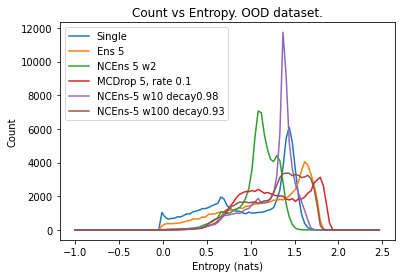

In [11]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. OOD dataset.')

Text(0.5, 1.0, 'Count vs Confidence. OOD Data')

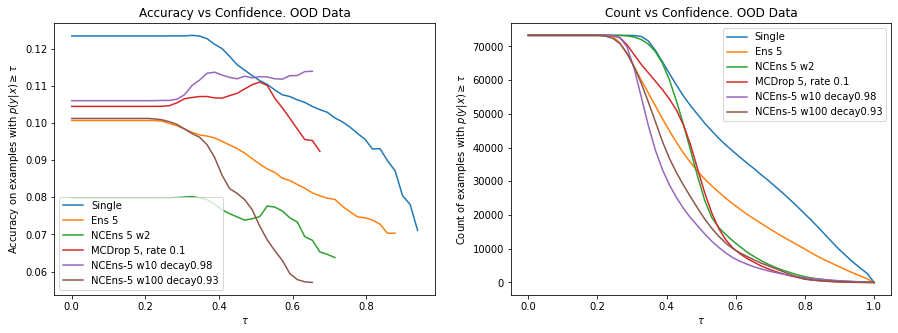

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. OOD Data')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. OOD Data')

In [5]:
# run_id = 'run-20210521_133234-2zgcfz21' # regular ens
run_id = 'run-20210521_135356-1z9btw0n' # nc ens
checkpoint_epoch = 180
device='cuda'

Initialising a negative-correlation normalised ensemble of 5 networks
SGD optimizer


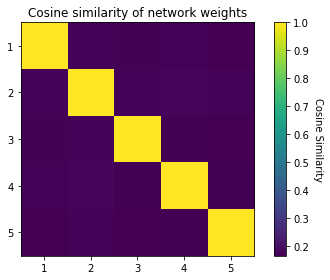

In [6]:
trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)
mat = plot_cosine_similarity(trainer)

In [7]:
test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, corruptions=constants.CORRUPTIONS, intensities=[3])


metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.40batch/s][0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.800e+01 3.200e+01
 9.300e+01 1.500e+02 1.620e+02 1.860e+02 2.910e+02 3.450e+02 3.660e+02
 7.672e+03]
[0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+01 5.400e+01 8.700e+01
 1.900e+02 2.600e+02 2.550e+02 2.600e+02 3.630e+02 3.860e+02 3.940e+02
 7.738e+03]
[0.         0.         0.         0.         0.4   

In [8]:
calibration_hist

(array([0.        , 0.        , 0.        , 0.        , 0.4       ,
        0.33333333, 0.36781609, 0.48947368, 0.57692308, 0.63529412,
        0.71538462, 0.80165289, 0.89378238, 0.92893401, 0.99147066]),
 array([0.        , 0.06666667, 0.13333334, 0.2       , 0.26666668,
        0.33333334, 0.4       , 0.46666667, 0.53333336, 0.6       ,
        0.6666667 , 0.73333335, 0.8       , 0.8666667 , 0.93333334,
        1.        ], dtype=float32))

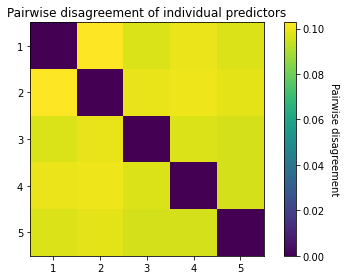

In [8]:
plot_disagreement_mat(disagreement_mat, remove_diag=False)

In [8]:
def plot_calibration_hist(calibration_hist):
    values, bins = calibration_hist

    width = bins[1] - bins[0]

    plt.bar(bins[:-1] + width/2, values, width*0.95)
    plt.plot(bins, bins, 'r--')

    plt.xlabel('confidence')
    plt.ylabel('accuracy')
    plt.show()

In [6]:
def run_plotting(run_id, name, corruption):
    has_subnets = not name == 'Single'
    print(name)
    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    print('Corruption intensity 3')
    
    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, 
                                            corruptions=constants.CORRUPTIONS, intensities=[corruption], 
                                            is_cifar10=model_args.dataset_type=='cifar10')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

    

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)
    
    if has_subnets:
        mat = plot_cosine_similarity(trainer, remove_diag=True)
        plot_disagreement_mat(disagreement_mat, remove_diag=False)
    plot_calibration_hist(calibration_hist)

    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, corruptions=constants.CORRUPTIONS, intensities=[5])
    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)

    print('Uncorrupted')
    if has_subnets:
        plot_disagreement_mat(disagreement_mat, remove_diag=False)
    plot_calibration_hist(calibration_hist)

Single
SGD optimizer
using multistep scheduler
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [00:19<00:00, 74.99batch/s]
[0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 6.1000e+01 2.7300e+02
 6.4400e+02 1.6030e+03 2.1540e+03 2.2930e+03 2.5300e+03 3.1140e+03
 3.9090e+03 6.4640e+03 1.0935e+05]
[0.00000e+00 0.00000e+00 0.00000e+00 3.20000e+01 2.83000e+02 1.17500e+03
 2.44400e+03 5.05700e+03 6.17800e+03 6.2

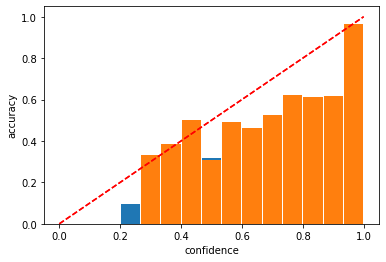

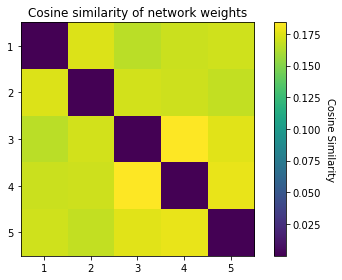

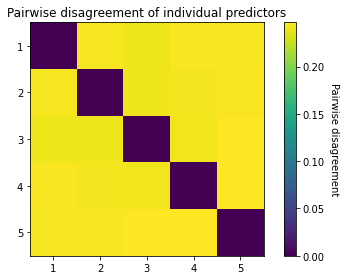

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.60batch/s]
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.100e+01 5.500e+01
 8.600e+01 1.340e+02 1.590e+02 1.790e+02 2.450e+02 3.400e+02 3.450e+02
 7.797e+03]
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 5.100e+01 1.090e+02
 1.690e+02 2.290e+02 2.370e+02 2.350e+02 3.180e+02 3.890e+02 3.870e+02
 7.869e+03]
[0.         0.         0.         0.         0.285

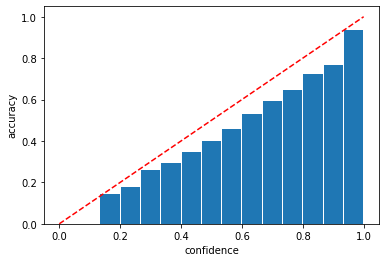

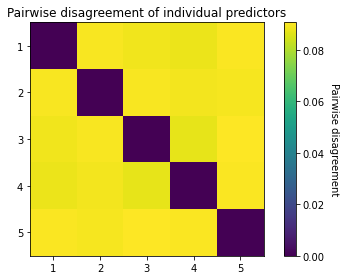

CEEns 5 w0.8
Initialising a pairwise cross-entropy regularised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:14<00:00, 19.84batch/s]
[0.0000e+00 0.0000e+00 4.0000e+00 1.4300e+02 8.1800e+02 2.2320e+03
 3.9660e+03 5.6550e+03 6.8540e+03 7.1850e+03 7.4270e+03 9.3760e+03
 1.1130e+04 1.2220e+04 7.3721e+04]
[0.0000e+00 0.0000e+00 1.6000e+01 6.5000e+02 3.1120e+03 7.09

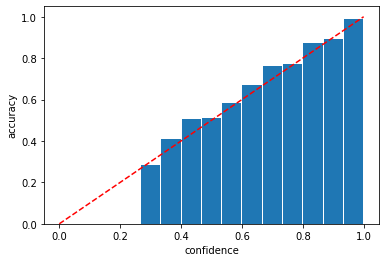

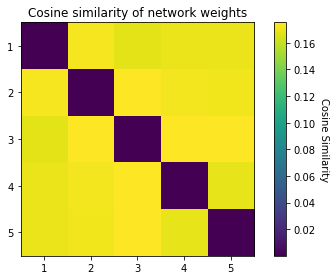

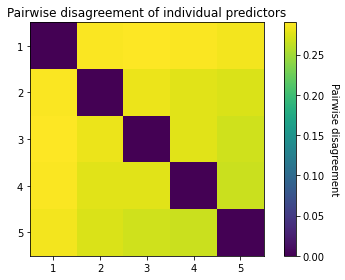

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.53batch/s]
[0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.000e+00 3.700e+01 6.600e+01
 1.210e+02 1.660e+02 2.080e+02 2.190e+02 3.160e+02 4.190e+02 5.550e+02
 7.238e+03]
[0.000e+00 0.000e+00 0.000e+00 5.000e+00 2.500e+01 9.400e+01 1.310e+02
 2.340e+02 2.720e+02 2.710e+02 2.800e+02 3.700e+02 4.550e+02 5.870e+02
 7.276e+03]
[0.         0.         0.         0.2        0.32 

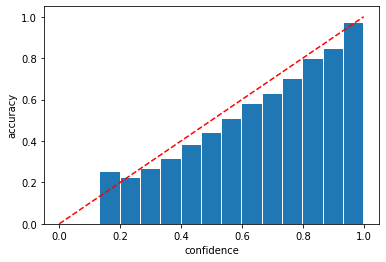

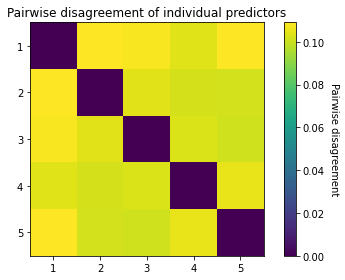

NCEns-5 w100 decay0.93
Initialising a negative-correlation normalised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:15<00:00, 19.72batch/s]
[0.0000e+00 0.0000e+00 2.0000e+00 1.2700e+02 7.7400e+02 2.3730e+03
 4.6700e+03 6.1070e+03 7.4740e+03 8.1410e+03 7.8580e+03 1.0304e+04
 1.0929e+04 1.1437e+04 7.3252e+04]
[0.0000e+00 0.0000e+00 1.1000e+01 5.4700e+02 2.8590e+

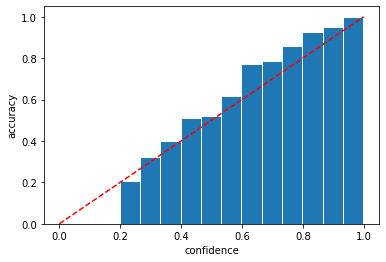

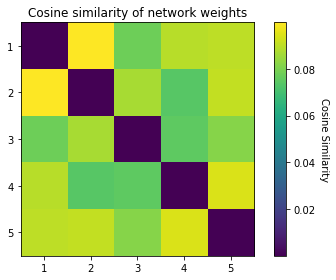

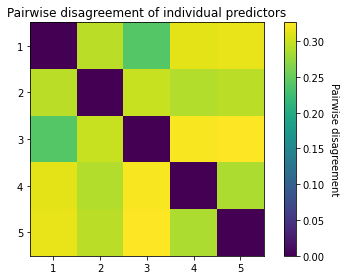

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.95batch/s]
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 4.100e+01 8.100e+01
 1.440e+02 2.090e+02 2.380e+02 2.640e+02 3.490e+02 4.700e+02 5.310e+02
 6.883e+03]
[0.000e+00 0.000e+00 0.000e+00 3.000e+00 2.600e+01 9.400e+01 1.700e+02
 2.820e+02 3.260e+02 3.360e+02 3.390e+02 4.120e+02 5.120e+02 5.640e+02
 6.936e+03]
[0.         0.         0.         0.         0.192

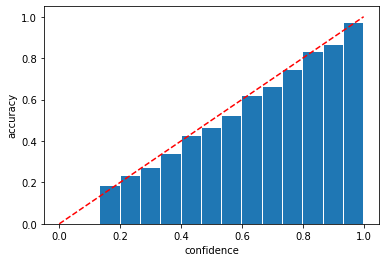

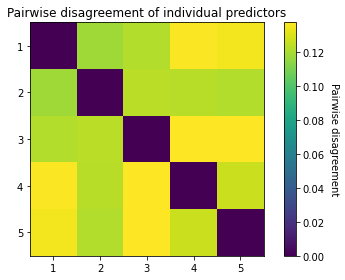

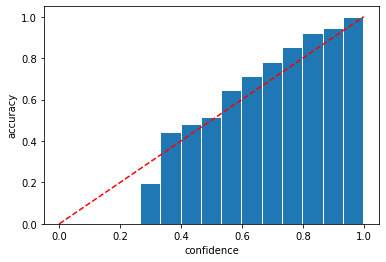

In [26]:
for run_id, name in checkpoints:
    run_plotting(run_id, name, 3)

### Calibration plots
(in "corrupted, og test" data order)

#### Single Net

Single
SGD optimizer
using multistep scheduler
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [00:19<00:00, 75.03batch/s]
Results: 
Accuracy: 0.6968315789473685
NLL: 1.7828214531446758
ECE: 0.22573060405019083
Brier: 0.5002524847733347
confidence: 4.784730242361982e-06


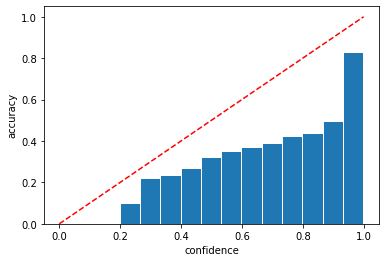

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:01<00:00, 59.61batch/s]
Results: 
Accuracy: 0.915
NLL: 0.3810369907915592
ECE: 0.07057033222019672
Brier: 0.13877249765992164
confidence: 9.679126372337341e-05
Uncorrupted


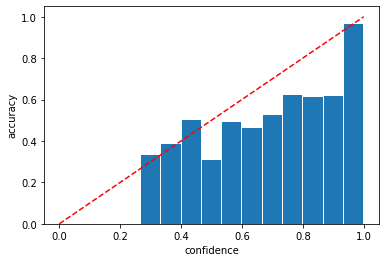

In [9]:
run_id, name = checkpoints[0]
run_plotting(run_id, name, 3)

#### Simple Deep Ensemble

Ens 5
Initialising an ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:15<00:00, 19.72batch/s]
Results: 
Accuracy: 0.7417263157894737
NLL: 1.0370572424336484
ECE: 0.12180372175197852
Brier: 0.37359775037514537
disagreement: 1.2800083102493069e-06
component accuracy: 3.7049473684210505e-06
confidence: 4.3307168958457885e-06


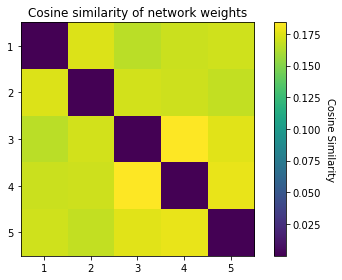

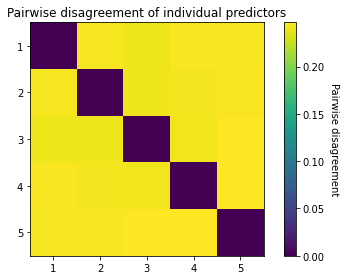

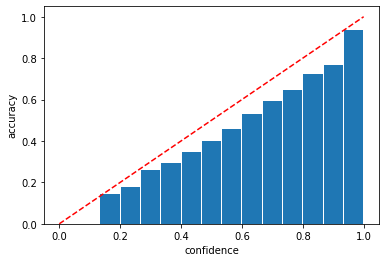

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.39batch/s]
Results: 
Accuracy: 0.9363
NLL: 0.20722052334547042
ECE: 0.05282195369303226
Brier: 0.09686144287586212
disagreement: 8.938000000000007e-06
component accuracy: 9.127799999999999e-05
confidence: 9.355979125022889e-05
Uncorrupted


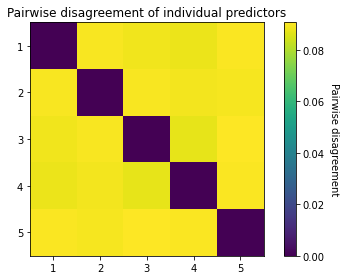

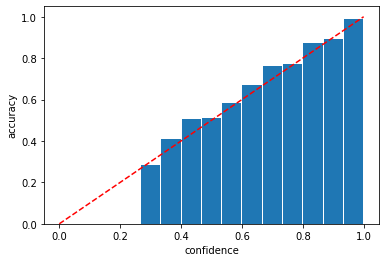

In [10]:
run_id, name = checkpoints[1]
run_plotting(run_id, name, 3)

#### Cross-entropy regularised deep ensemble with weight 0.8

CEEns 5 w0.8
Initialising a pairwise cross-entropy regularised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:16<00:00, 19.49batch/s]
Results: 
Accuracy: 0.7406894736842106
NLL: 0.8942813937689129
ECE: 0.10402941328710631
Brier: 0.3651522283328207
disagreement: 1.4717617728531842e-06
component accuracy: 3.638808864265927e-06
confidence: 4.1204809954952334e-06


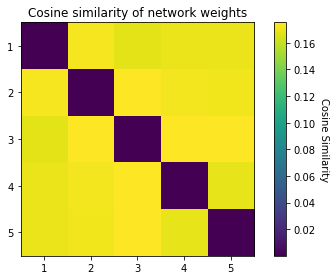

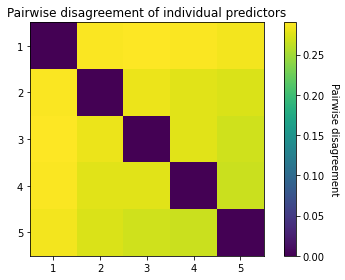

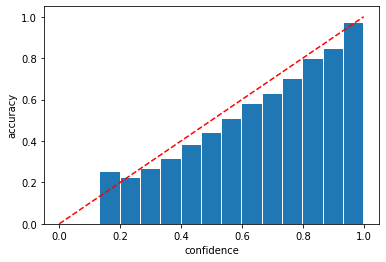

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.22batch/s]
Results: 
Accuracy: 0.9354
NLL: 0.20531393814086915
ECE: 0.055747380001842976
Brier: 0.09823427608013154
disagreement: 1.0475999999999996e-05
component accuracy: 9.059599999999998e-05
confidence: 9.160983984947204e-05
Uncorrupted


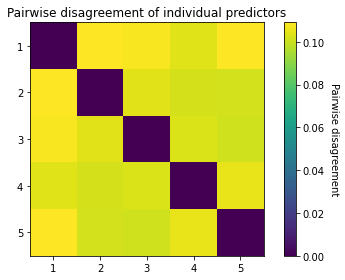

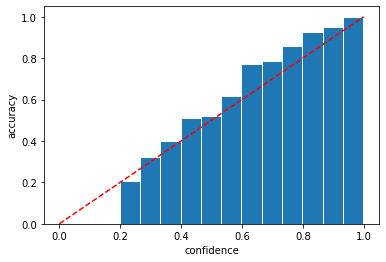

In [12]:
run_id, name = checkpoints[2]
run_plotting(run_id, name, 3)

#### Negative correlation regularised deep ensemble with weight 100, decay 0.93

NCEns-5 w100 decay0.93
Initialising a negative-correlation normalised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:14<00:00, 19.86batch/s]
Results: 
Accuracy: 0.7549894736842105
NLL: 0.7983098720399957
ECE: 0.10053798114194681
Brier: 0.34369637181884366
disagreement: 1.5669750692520756e-06
component accuracy: 3.6666648199445967e-06
confidence: 4.1052016656088

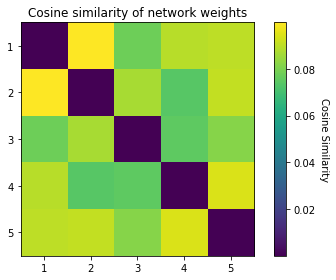

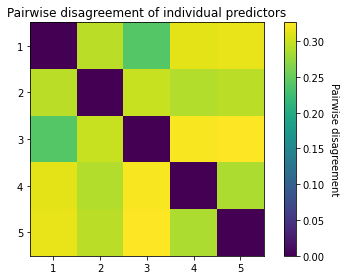

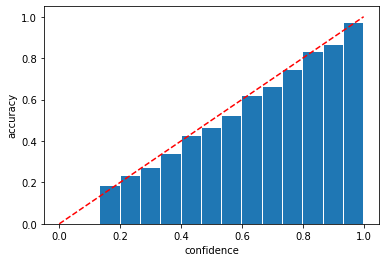

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.42batch/s]
Results: 
Accuracy: 0.9215
NLL: 0.24614939794540405
ECE: 0.06183146897554397
Brier: 0.11853548533916473
disagreement: 1.2794999999999995e-05
component accuracy: 8.8604e-05
confidence: 9.04154861164093e-05
Uncorrupted


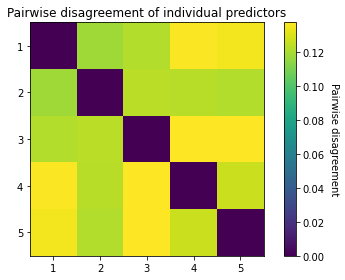

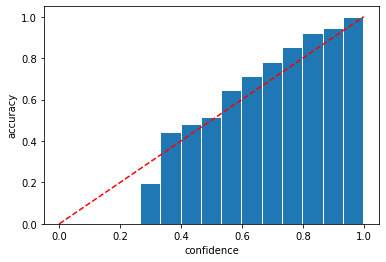

In [13]:
run_id, name = checkpoints[3]
run_plotting(run_id, name, 3)